In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
## Import data from https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
## Shapefile enables plotting of census tracts, neighborhoods, borough, etc. by coordinates
census_tract_shapes = gpd.read_file('data/geo_export_e2cd3cf8-21c0-468e-9274-ad3af1e7d5c9.shp')

In [3]:
nyc_tree = pd.read_csv('data/2015_Street_Tree_Census_-_Tree_Data.csv')
nyc_tree = nyc_tree.loc[nyc_tree.status == 'Alive'] 

In [4]:
## Allows for counting of rows when using groupby function
nyc_tree['counter'] = 1

In [5]:
nyc_tree.health.value_counts()

Good    528850
Fair     96504
Poor     26818
Name: health, dtype: int64

In [6]:
nyc_tree['good_health_tree'] = nyc_tree.health.apply(lambda x: 1 if x=='Good' else 0)
nyc_tree['fair_health_tree'] = nyc_tree.health.apply(lambda x: 1 if x=='Fair' else 0)
nyc_tree['poor_health_tree'] = nyc_tree.health.apply(lambda x: 1 if x=='Poor' else 0)

In [7]:
## Reduce number of shapes from 2165 census tracts to 195 neighborhoods
neighborhood_shapes = census_tract_shapes.dissolve(by='ntaname')

In [8]:
neighborhood_trees = nyc_tree.groupby('nta_name').sum()

In [9]:
## Join shape dataset and tree dataset on neighborhood name indexes
trees_by_neighborhood = neighborhood_trees.join(neighborhood_shapes)

In [10]:
trees_by_neighborhood = gpd.GeoDataFrame(trees_by_neighborhood)

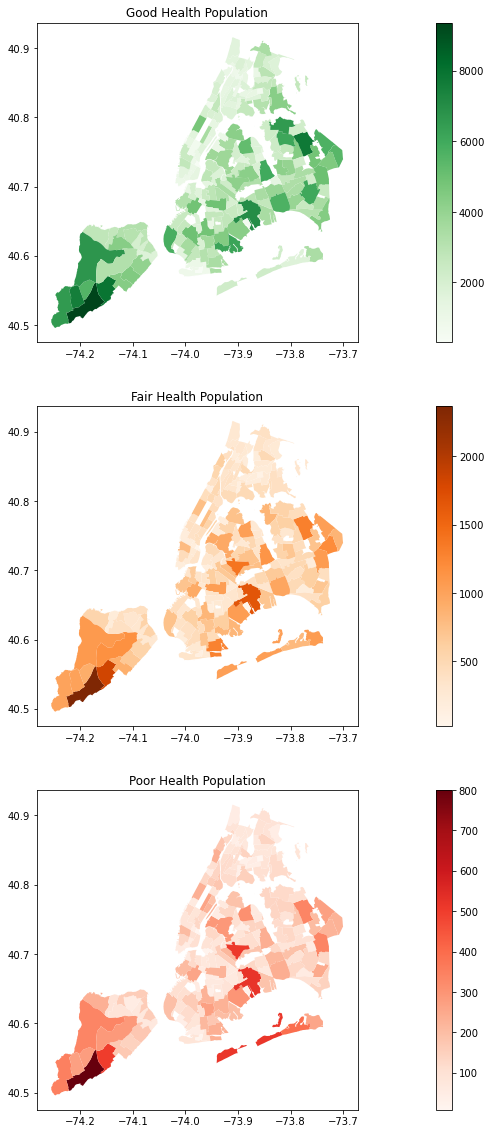

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(28, 20))
ax1 = (trees_by_neighborhood.plot(ax=ax1, column='good_health_tree', legend=True, cmap='Greens')
                            .set_title('Good Health Population'))
ax2 = (trees_by_neighborhood.plot(ax=ax2, column='fair_health_tree', legend=True, cmap='Oranges')
                            .set_title('Fair Health Population'))
ax3 = (trees_by_neighborhood.plot(ax=ax3, column='poor_health_tree', legend=True, cmap='Reds')
                            .set_title('Poor Health Population'));

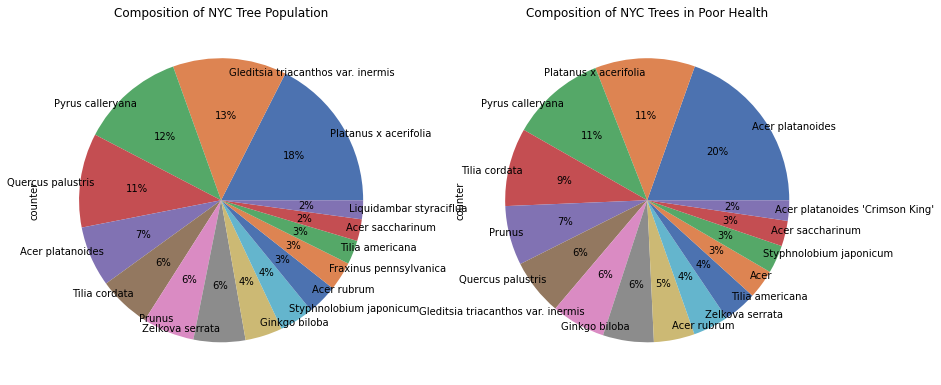

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))
ax1 = (nyc_tree.groupby('spc_common')['counter'].count().nlargest(15).plot(ax=ax1, kind='pie', colors=sns.color_palette('deep'),
       labels=nyc_tree.groupby('spc_latin')['counter'].count().nlargest(15).index,
       autopct='%1.0f%%', labeldistance=.9)
       .set_title('Composition of NYC Tree Population'))
ax2 = (nyc_tree.loc[nyc_tree.health == 'Poor'].groupby('spc_common')['counter'].count().nlargest(15).plot(ax=ax2, kind='pie',
       colors=sns.color_palette('deep'),
       labels=nyc_tree.loc[nyc_tree.health == 'Poor'].groupby('spc_latin')['counter'].count().nlargest(15).index,
       autopct='%1.0f%%',labeldistance=.9).set_title('Composition of NYC Trees in Poor Health'));